In [85]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

# Статья
# https://habr.com/ru/company/ods/blog/327242/

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)



In [6]:
dataset = pd.read_csv(r'C:\Users\parsh\Desktop\Exchange\data\US_stocks_csv_85_89\US_stocks_csv_85_89\AMEX/ACU.csv', index_col=['Date'], parse_dates=['Date'])
plotly_df(dataset, title = "Stocks")

In [7]:
ads = pd.read_csv(r'C:\Users\parsh\Desktop\Exchange\data\mlcourse/ads.csv', index_col=['Time'], parse_dates=['Time'])

In [8]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Close, 24)

4.307291666666667

In [9]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
#     plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

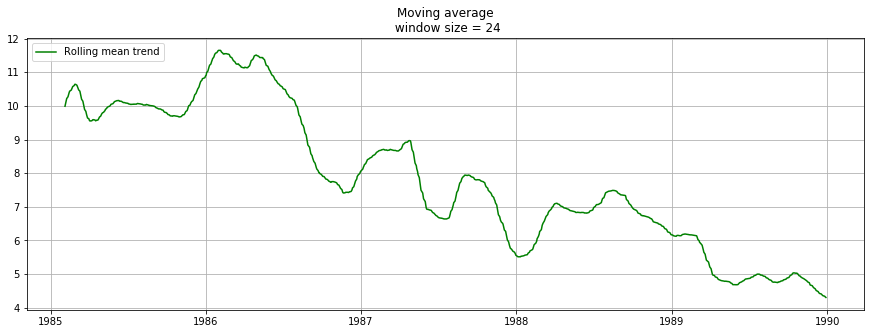

In [10]:
plotMovingAverage(dataset.Close, 24) # сглаживаем по дням
# plotMovingAverage(dataset.Close, 24*7) # сглаживаем по неделям

In [11]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Close, [0.6, 0.2, 0.1, 0.07, 0.03])

4.1875

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

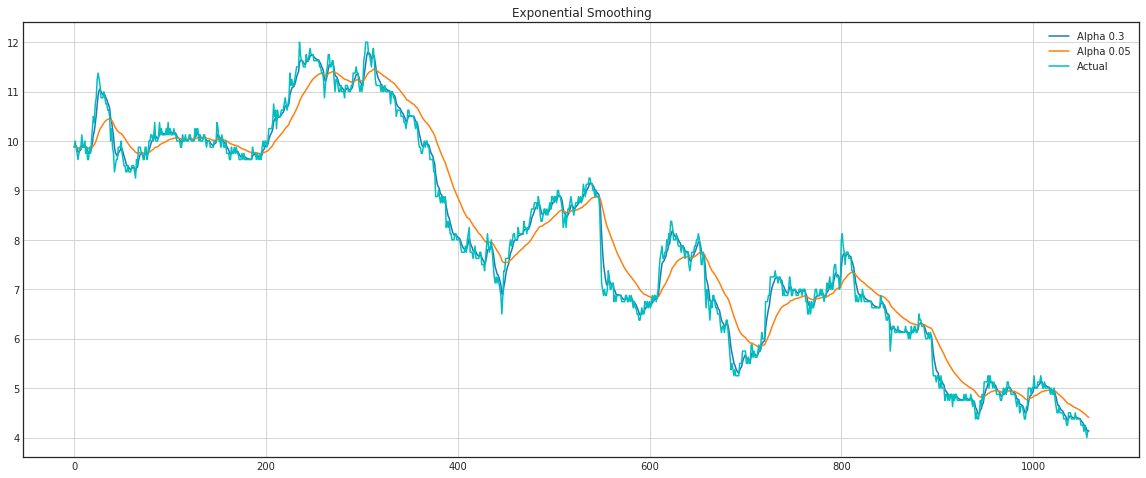

In [13]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Close, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Close.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

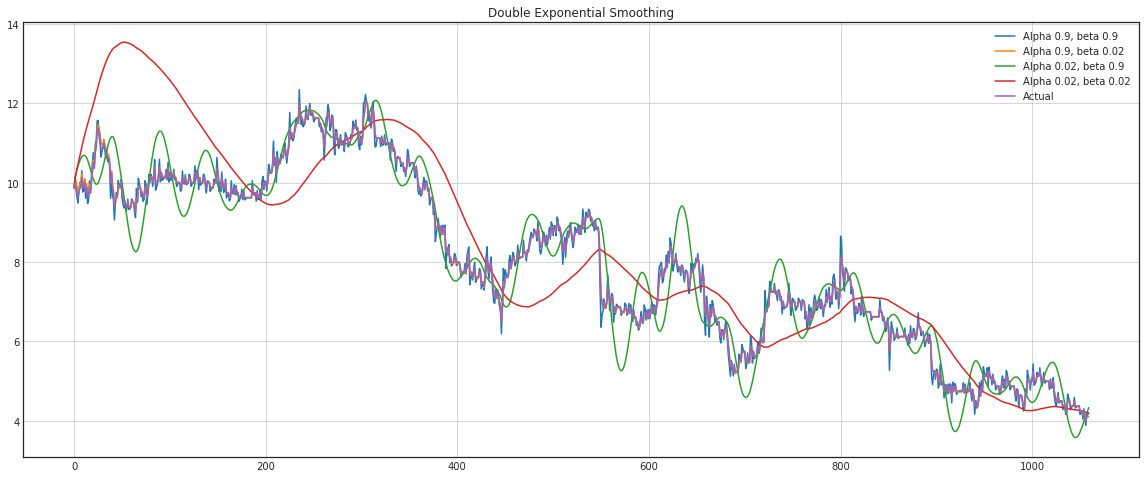

In [15]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Close, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Close.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# Cross Validation

In [16]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [17]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [19]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [20]:
currency = dataset.copy()
data = currency.Close[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()
model

0.06341544986323605 0.0 0.2607965535161726


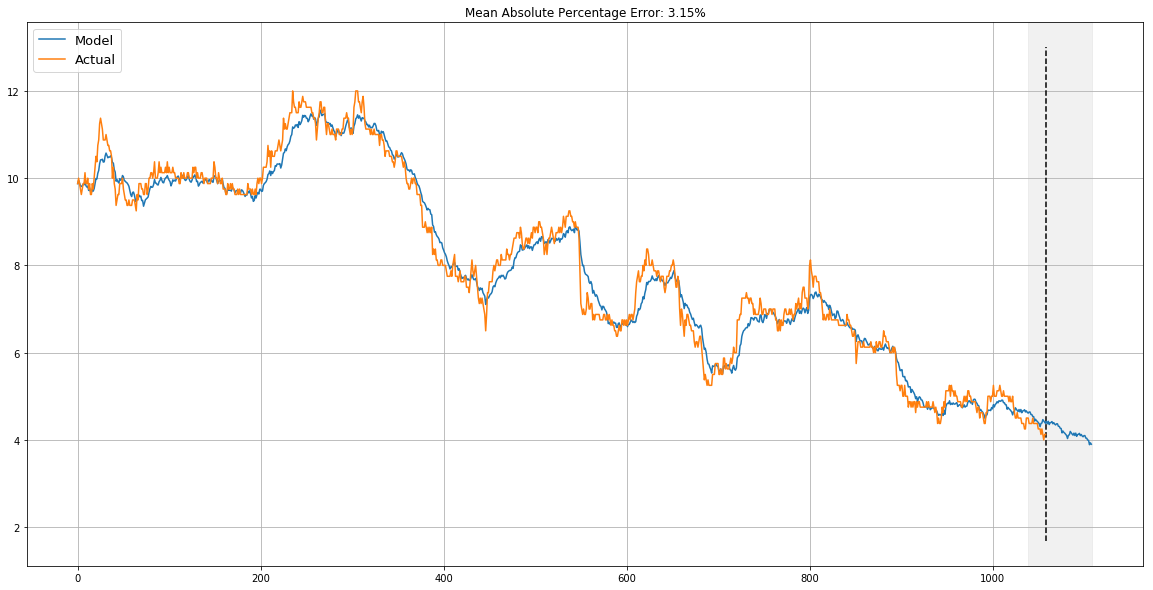

In [21]:
plotHoltWinters(currency.Close)

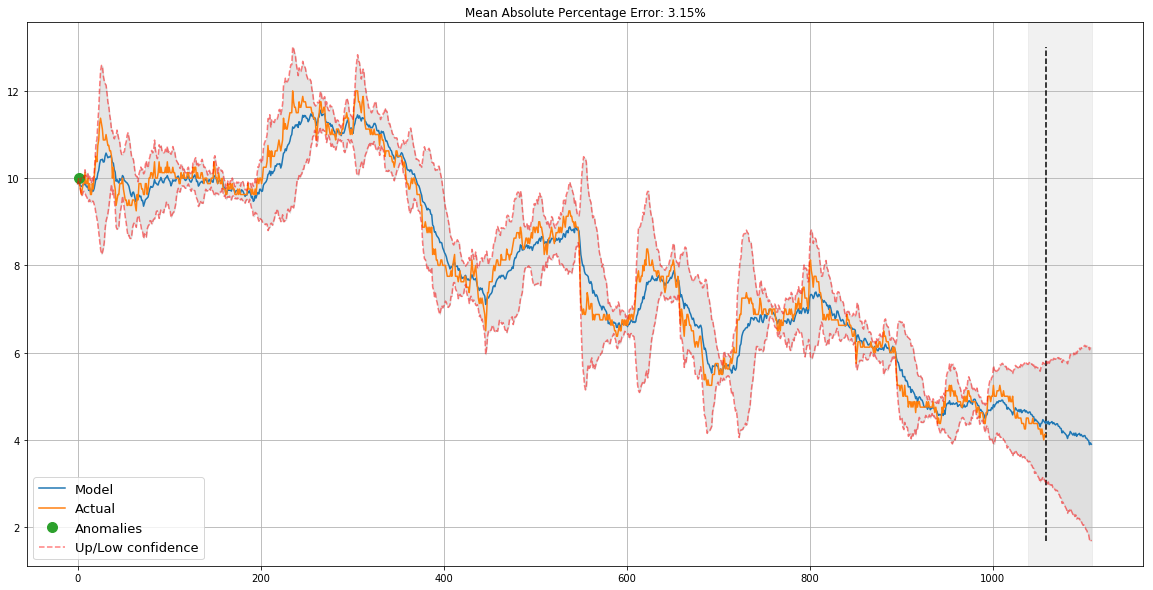

In [22]:
plotHoltWinters(currency.Close, plot_intervals=True, plot_anomalies=True)

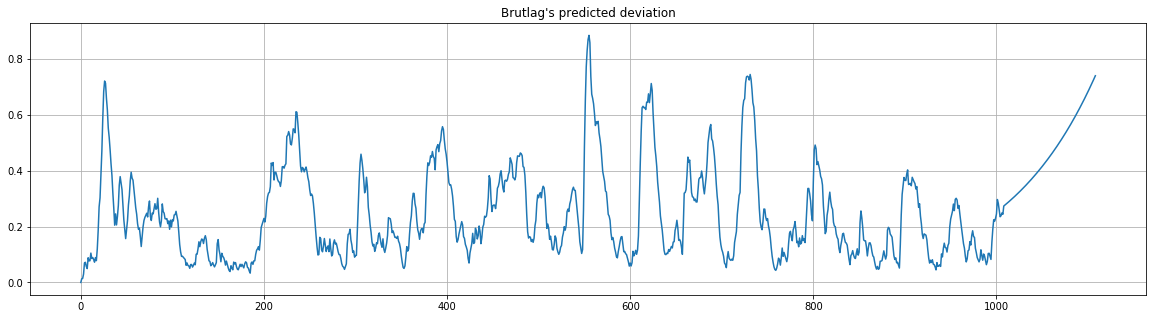

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# Arima model

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

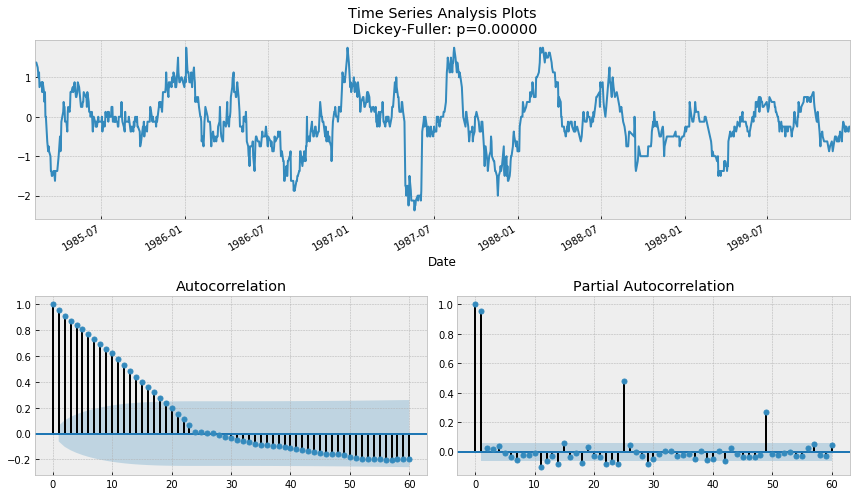

In [27]:
ads_diff = dataset.Close - dataset.Close.shift(24)
tsplot(ads_diff[24:], lags=60)

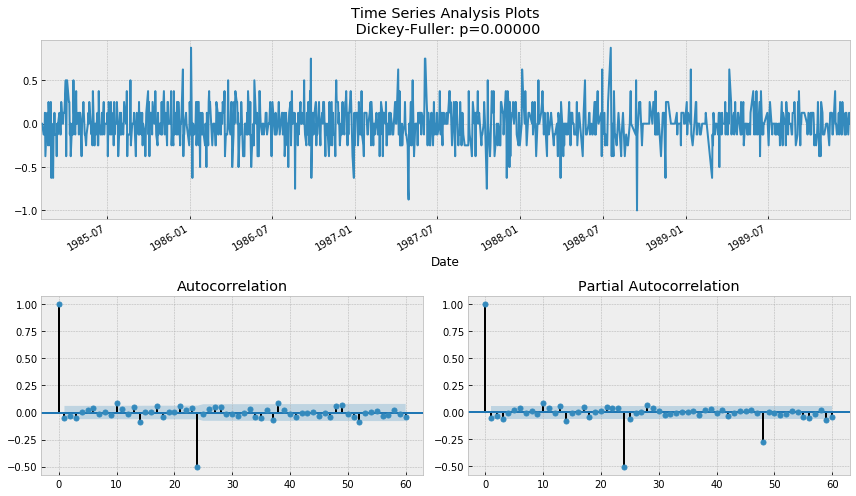

In [28]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [ ]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

                  # some useful functions




%matplotlib inline

In [30]:
from itertools import product  

# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [37]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [32]:
model=sm.tsa.statespace.SARIMAX(dataset.Close, order=(2, d, 3), 
                                            seasonal_order=(1, D, 1, s)).fit(disp=-1)

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [38]:
from tqdm import tqdm_notebook
# %%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was

In [39]:
# set the parameters that give the lowest AIC
p, q, P, Q = 2,3,1,1

In [40]:
best_model=sm.tsa.statespace.SARIMAX(dataset.Close, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                 
Dep. Variable:                              Close   No. Observations:                 1059
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood                 402.410
Date:                            Mon, 22 Jul 2019   AIC                           -788.819
Time:                                    16:47:34   BIC                           -749.290
Sample:                                         0   HQIC                          -773.820
                                           - 1059                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2007      0.459      0.437      0.662      -0.699       1.100
ar.L2         -0.6602      0.436   

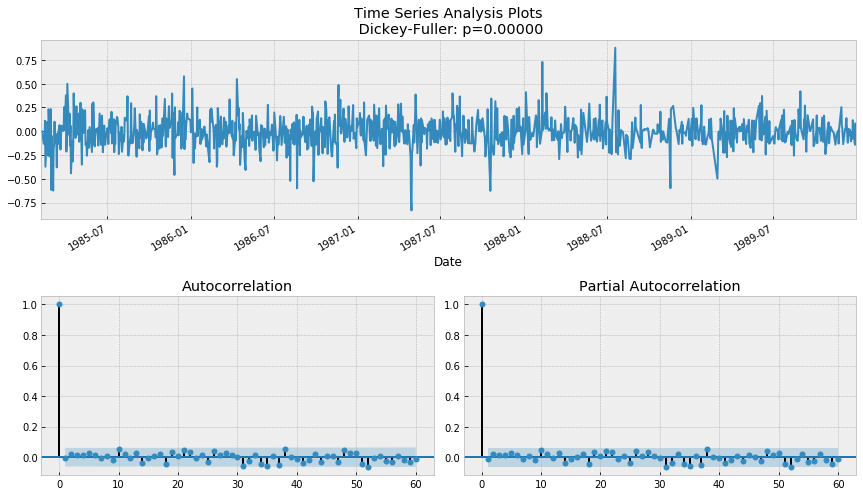

In [41]:
tsplot(best_model.resid[24+1:], lags=60)

In [42]:

"""
    Plots model vs predicted values

    series - dataset with timeseries
    model - fitted SARIMA model
    n_steps - number of steps to predict in the future

"""
n_steps=50
# adding model values
data = dataset.copy()
model = best_model
data.drop(['Ticker', 'Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data.columns = ['actual']
data['arima_model'] = model.fittedvalues

In [43]:
# making a shift on s+d steps, because these values were unobserved by the model
# due to the differentiating
data['arima_model'][:s+d] = np.NaN

In [44]:

# forecasting on n_steps forward 
forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [45]:

forecast = data.arima_model.append(forecast)

In [46]:

# calculate error, again having shifted on s+d steps from the beginning
error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

In [48]:
plt.figure(figsize=(15, 7))

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Mean Absolute Percentage Error: 1.60%')

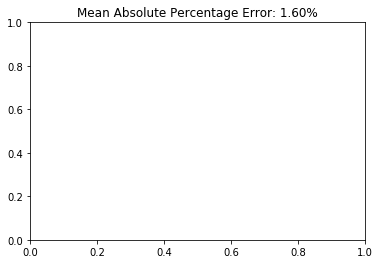

In [49]:
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

In [51]:
forecast = forecast.reset_index(name='values')

In [52]:
forecast.columns

Index(['index', 'values'], dtype='object')

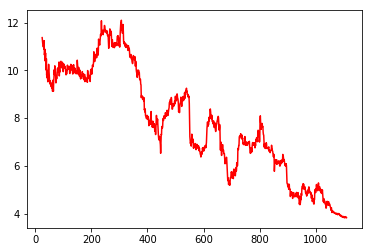

In [53]:
plt.plot(forecast['values'], color='r', label="model")

In [55]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(dataset.Close.copy())
data.columns = ["y"]

In [58]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [59]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Date,,,,,,,,,,,,,,,,,,,,
1989-12-20,4.250,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375,4.375,4.500,4.500,4.500,4.500
1989-12-21,4.125,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375,4.375,4.500,4.500,4.500
1989-12-22,4.250,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375,4.375,4.500,4.500
1989-12-26,4.125,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375,4.375,4.500
1989-12-27,4.000,4.250,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375,4.375
1989-12-28,4.125,4.250,4.250,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375,4.375
1989-12-29,4.125,4.250,4.250,4.250,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,4.500,4.500,4.500,4.250,4.250,4.375


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [61]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [62]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [63]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [64]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

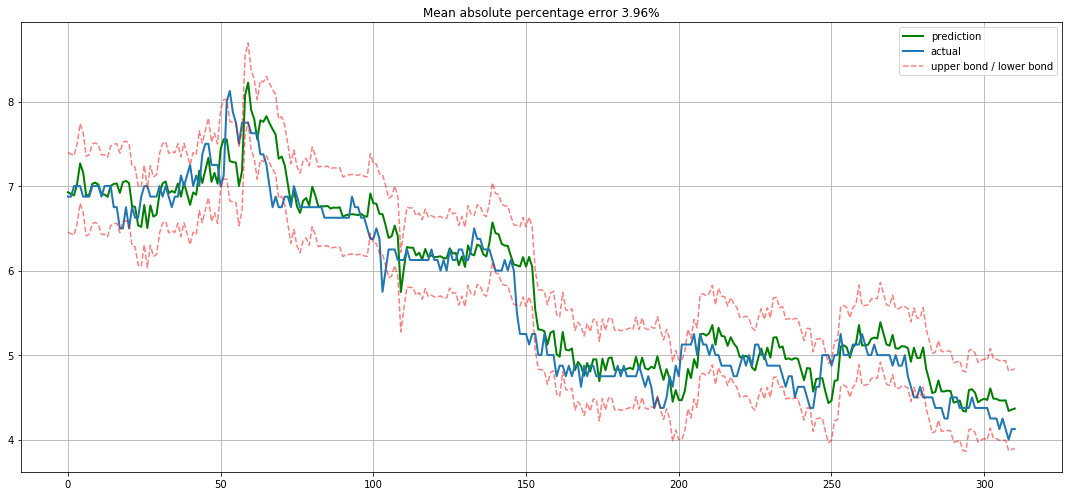

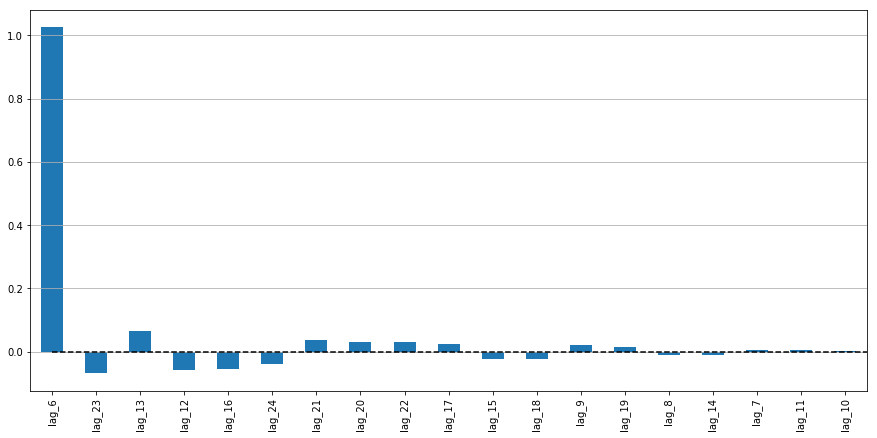

In [65]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [66]:
data.index = pd.to_datetime(data.index)

In [67]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
Date,,,,,,,,,,,,,,,,,,,,,
1989-12-22,4.250,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,4.375,...,4.500,4.250,4.25,4.375,4.375,4.375,4.500,4.500,4,0
1989-12-26,4.125,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,4.375,...,4.500,4.500,4.25,4.250,4.375,4.375,4.375,4.500,1,0
1989-12-27,4.000,4.250,4.375,4.375,4.375,4.375,4.375,4.500,4.375,4.375,...,4.500,4.500,4.50,4.250,4.250,4.375,4.375,4.375,2,0
1989-12-28,4.125,4.250,4.250,4.375,4.375,4.375,4.375,4.375,4.500,4.375,...,4.375,4.500,4.50,4.500,4.250,4.250,4.375,4.375,3,0
1989-12-29,4.125,4.250,4.250,4.250,4.375,4.375,4.375,4.375,4.375,4.500,...,4.375,4.375,4.50,4.500,4.500,4.250,4.250,4.375,4,0


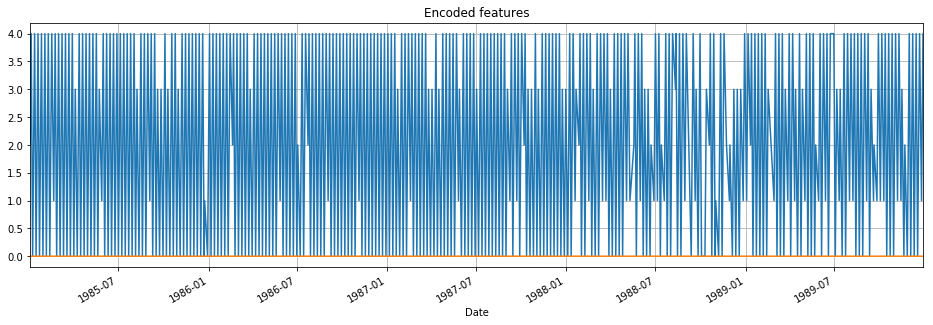

In [68]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.



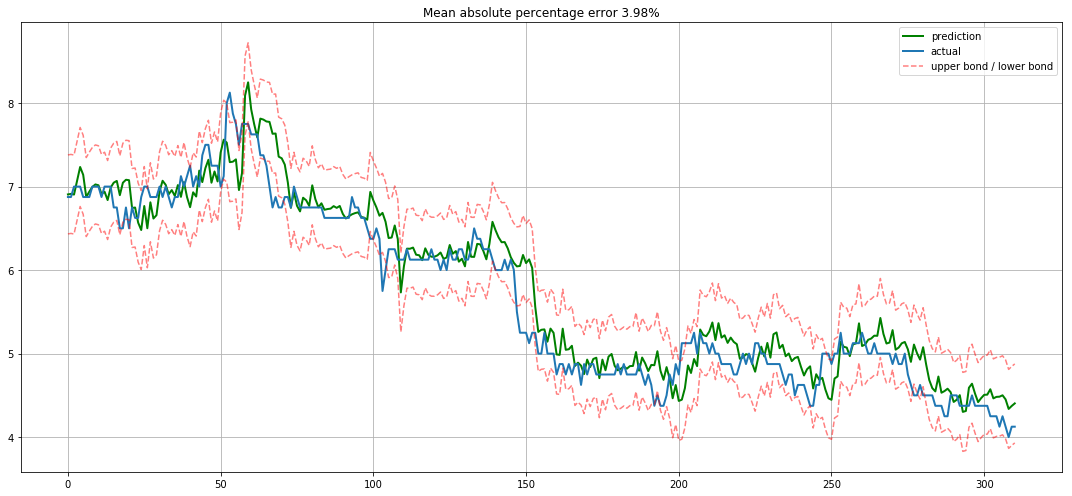

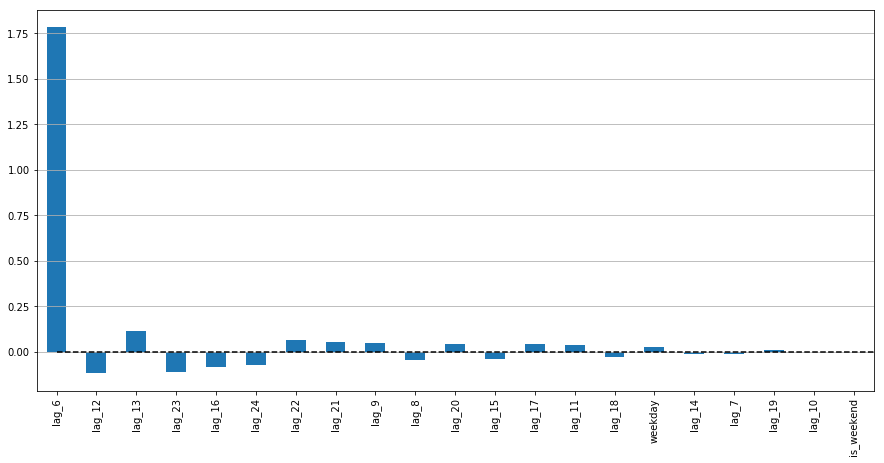

In [70]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [71]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [72]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        

        # frop encoded variables 
        data.drop([ "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.



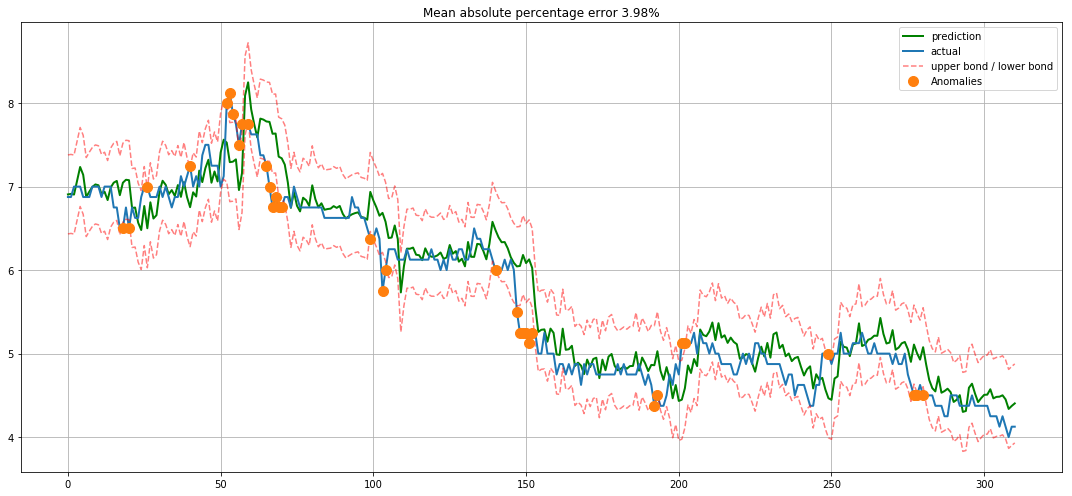

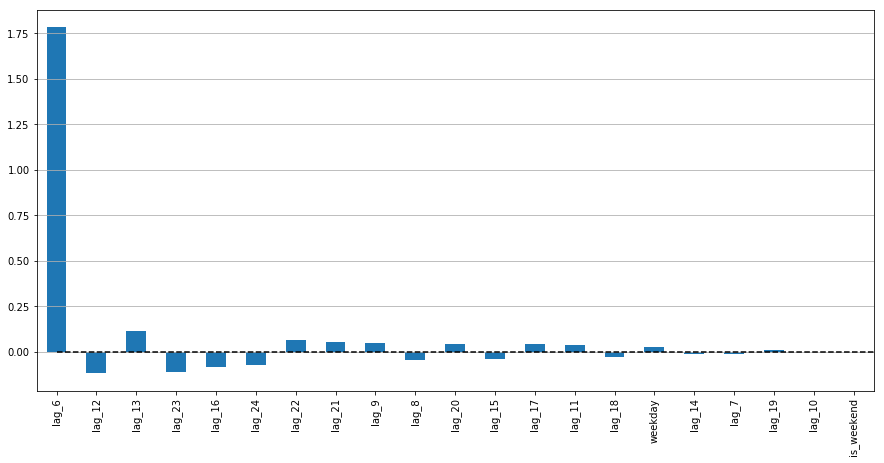

In [76]:

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [77]:
X_train, X_test, y_train, y_test =\
prepareData(dataset.Close, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\parsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.



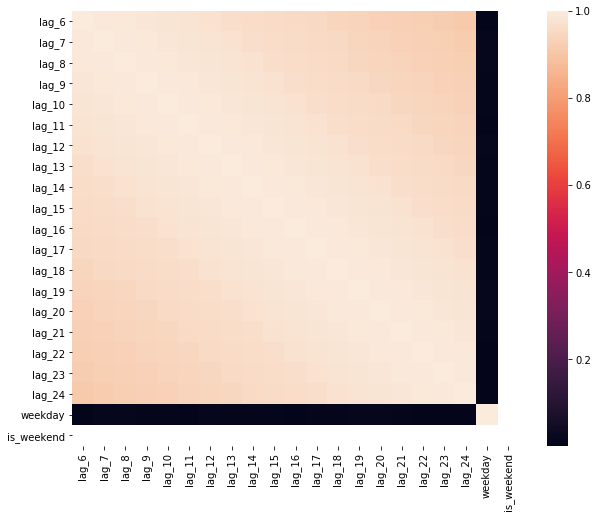

In [79]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

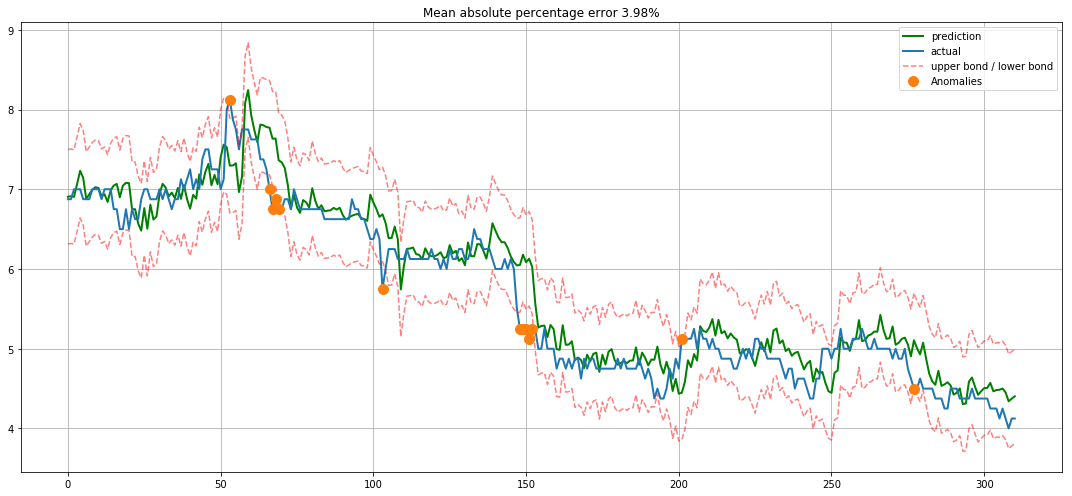

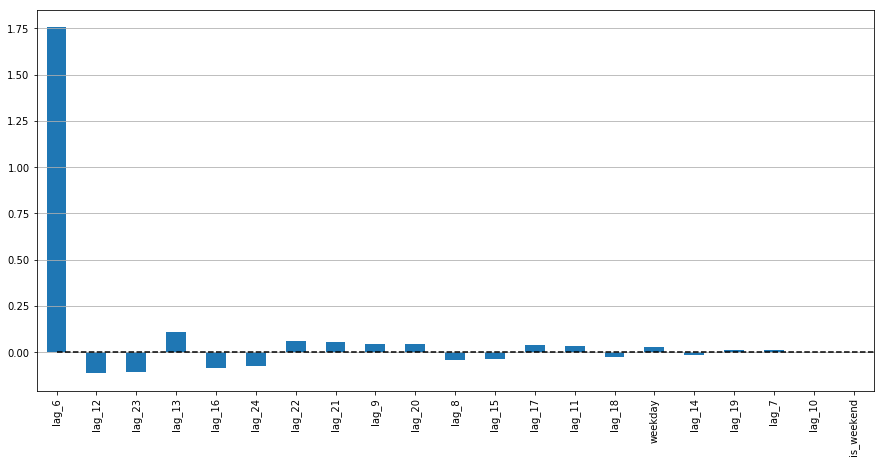

In [80]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

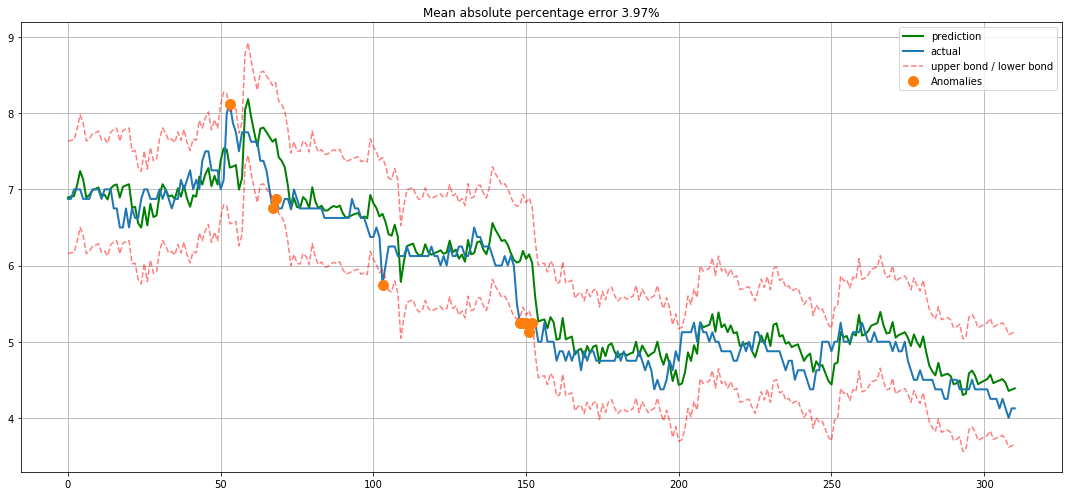

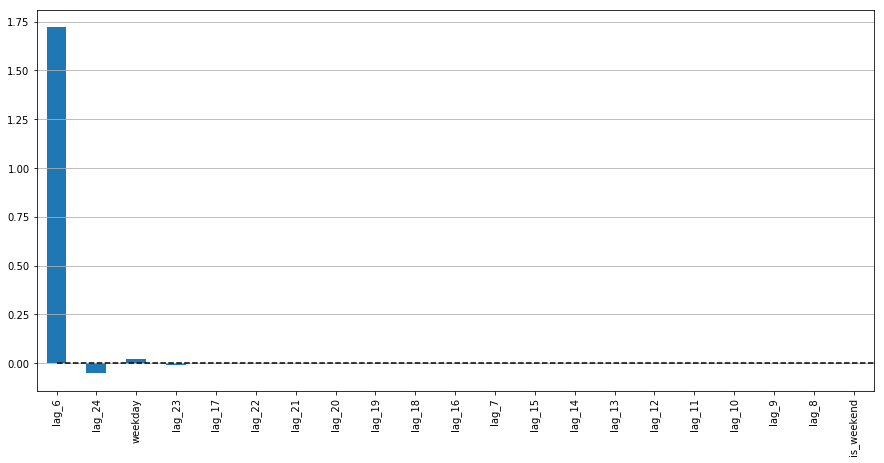

In [81]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [82]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

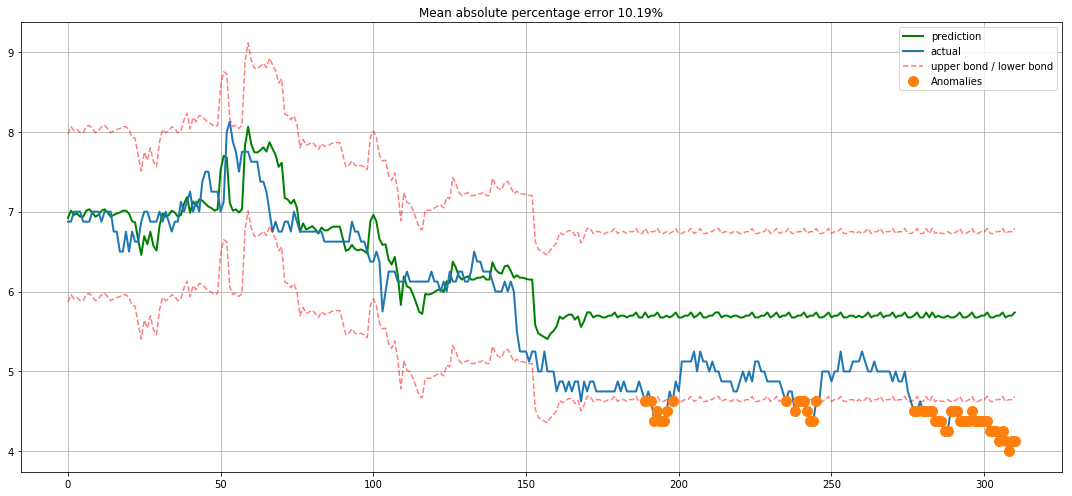

In [83]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)